In [177]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
from gantools.data.transformation import tf_flip_slices_1d, tf_flip_slices_2d, tf_flip_slices_3d
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [65]:
tf.enable_eager_execution()


In [289]:
def fill_void(dat, axis):
    naxis = len(dat.shape)-1
    l,r = tf.split(dat,2, axis=axis)
    m = tf.cast(tf.reduce_sum(tf.abs(l),axis=[range(1,naxis)], keep_dims=True)>0, dtype=tf.float32)
    l = l*m + tf.reverse(r,axis=[axis])*(1-m)
    return tf.concat((l,r), axis=axis)

In [290]:
def tf_patch2img_1d(r, l, use_symetry=False):
    imgs = tf.concat([l, r], axis=1)
    if use_symetry:
        imgs = fill_void(imgs, axis=1)
    return imgs

In [291]:
sig1d = np.random.rand(3,4,7).astype(np.float32)
sig1d0 = np.zeros((3,4,7)).astype(np.float32)

In [292]:
# global test
r1 = tf_patch2img_1d(sig1d, tf_flip_slices_1d(sig1d), use_symetry=True)
r2 = tf_patch2img_1d(sig1d, sig1d0, use_symetry=True)
np.testing.assert_allclose(r1,r2)

In [293]:
# per sample test
sig1d02 = np.concatenate((sig1d0[2:], tf_flip_slices_1d(sig1d)[:2]), axis=0)
r1 = tf_patch2img_1d(sig1d, tf_flip_slices_1d(sig1d), use_symetry=True)
r2 = tf_patch2img_1d(sig1d, sig1d0, use_symetry=True)
np.testing.assert_allclose(r1,r2)

In [294]:
def tf_patch2img_2d(dr, dl, ur, ul, use_symetry=False):
    imgs_d = tf.concat([dl, dr], axis=1)
    imgs_u = tf.concat([ul, ur], axis=1)
    imgs = tf.concat([imgs_u,  imgs_d], axis=2)
    if use_symetry:
        imgs = fill_void(imgs, axis=1)
        imgs = fill_void(imgs, axis=2)
    return imgs

In [295]:
sig2dr = np.random.rand(1,4,4,1).astype(np.float32)
sig2dl = np.random.rand(1,4,4,1).astype(np.float32)
sig2d0 = np.zeros((1,4,4,1)).astype(np.float32)

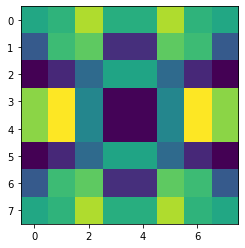

In [296]:

img = tf_patch2img_2d(sig2dr, sig2d0, sig2d0, sig2d0, use_symetry=True)[0,:,:,0]
plt.imshow(img)

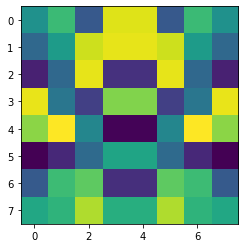

In [297]:

img = tf_patch2img_2d(sig2dr, sig2dl, sig2d0, sig2d0, use_symetry=True)[0,:,:,0]
plt.imshow(img)

In [298]:
sig2dr = np.random.rand(5,4,4,3).astype(np.float32)
sig2dl = np.random.rand(5,4,4,3).astype(np.float32)
sig2dl2 = np.random.rand(5,4,4,3).astype(np.float32)
sig2d0 = np.zeros((5,4,4,3)).astype(np.float32)



In [299]:
# global test
sig2dr_dl, sig2dr_ur, sig2dr_ul = tf_flip_slices_2d(sig2dr, sig2dr, sig2dr)
r1 = tf_patch2img_2d(sig2dr, sig2dr_dl, sig2dr_ur, sig2dr_ul, use_symetry=True)
r2 = tf_patch2img_2d(sig2dr, sig2d0, sig2d0, sig2d0, use_symetry=True)
np.testing.assert_allclose(r1,r2)

sig2dr_dl, sig2dr_ur, sig2dr_ul = tf_flip_slices_2d(sig2dr, sig2dr, sig2dr)
_, sig2dr_dl, _ = tf_flip_slices_2d(sig2dl,sig2dl, sig2dl)
r1 = tf_patch2img_2d(sig2dr, sig2dl, sig2dr_ur, sig2dr_dl, use_symetry=True)
r2 = tf_patch2img_2d(sig2dr, sig2dl, sig2d0, sig2d0, use_symetry=True)
np.testing.assert_allclose(r1,r2)

sig2dr_dl, sig2dr_ur, sig2dr_ul = tf_flip_slices_2d(sig2dr, sig2dr, sig2dr)
sig2dr_ul, _, _ = tf_flip_slices_2d(sig2dl,sig2dl, sig2dl)
r1 = tf_patch2img_2d(sig2dr, sig2dr_dl, sig2dl, sig2dr_ul, use_symetry=True)
r2 = tf_patch2img_2d(sig2dr,sig2d0, sig2dl, sig2d0, use_symetry=True)
np.testing.assert_allclose(r1,r2)



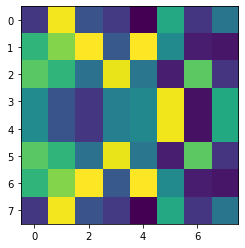

In [300]:
plt.imshow(r1[0,:,:,0])

In [301]:
from cosmotools.data.load import load_nbody_dataset
from cosmotools.data.fmap import forward
dataset = load_nbody_dataset(ncubes=1,forward_map=forward,patch=True)

Select 1 cubes out of 30.
images shape =  (1, 256, 256, 256)


In [302]:
samples = next(dataset.iter(100))

In [303]:
from gantools.plot import draw_images

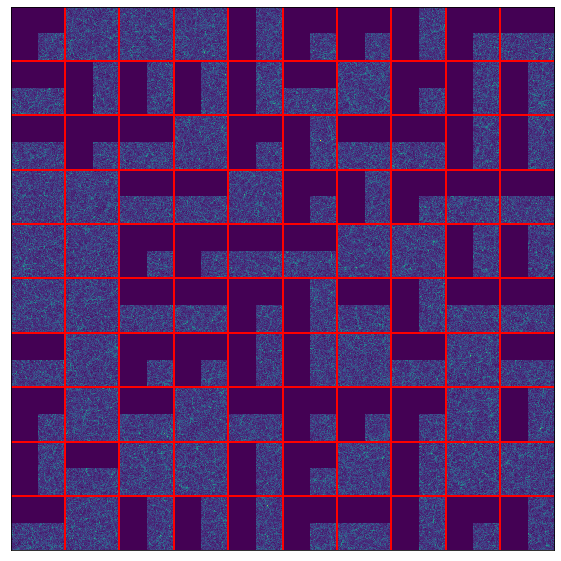

In [304]:
args = list(samples[:,:,:,i] for i in range(4))
imgs = tf_patch2img_2d(*args, use_symetry=False)
plt.figure(figsize=(10,10))
draw_images(imgs, 10,10)

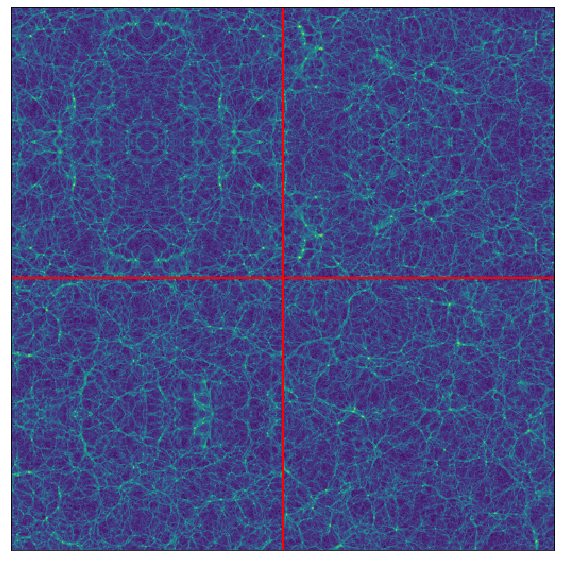

In [305]:
args = list(samples[:,:,:,i] for i in range(4))
imgs = tf_patch2img_2d(*args, use_symetry=True)
plt.figure(figsize=(10,10))
draw_images(imgs, 2,2)

In [306]:
args = list(samples[:,:,:,i] for i in range(4))
imgs = tf_patch2img_2d(*args, use_symetry=True)
d = imgs.shape[1]//2
img2 = np.concatenate((imgs[:,:d,:d], imgs[:,d:,:d], imgs[:,d:,:d] , imgs[:,d:,d:] ))
np.testing.assert_array_less(0, np.sum(np.sum(img2, axis=2), axis=1))

In [307]:
def tf_patch2img_3d(*args, use_symetry=False):
    imgs_down_left = tf.concat([args[3], args[2]], axis=2)
    imgs_down_right = tf.concat([args[1], args[0]], axis=2)
    imgs_down = tf.concat([imgs_down_left, imgs_down_right], axis=3)
    imgs_up_left = tf.concat([args[7], args[6]], axis=2)
    imgs_up_right = tf.concat([args[5], args[4]], axis=2)
    imgs_up = tf.concat([ imgs_up_left, imgs_up_right], axis=3)
    imgs = tf.concat([imgs_up, imgs_down], axis=1)
    if use_symetry:        
        imgs = fill_void(imgs, axis=1)
        imgs = fill_void(imgs, axis=2)        
        imgs = fill_void(imgs, axis=3)        
    return imgs

In [308]:
sig3d = list(np.random.rand(5,4,4,4,3).astype(np.float32) for _ in range(8))

sig3d0 = np.zeros((5,4,4,4,3)).astype(np.float32)
sig3d_f = tf_flip_slices_3d(*[sig3d[0]]*7)

In [316]:
args_1 = list((sig3d[0], *sig3d_f))
args_2 = list((sig3d[0], *[sig3d0]*7))

r1 = tf_patch2img_3d(*args_1, use_symetry=True)
r2 = tf_patch2img_3d(*args_2, use_symetry=True)
np.testing.assert_allclose(r1,r2)


In [326]:
dataset = load_nbody_dataset(ncubes=1,forward_map=forward,patch=True, is_3d=True)

Select 1 cubes out of 30.
images shape =  (1, 256, 256, 256)


In [332]:
samples = next(dataset.iter(8))

In [333]:
args = list(samples[:,:,:,:,i] for i in range(8))
imgs = tf_patch2img_3d(*args, use_symetry=True)
d = imgs.shape[1]//2
img2 = np.concatenate((imgs[:,:d,:d,:d], imgs[:,d:,:d,:d], imgs[:,d:,:d,:d] , imgs[:,d:,d:,:d],
                       imgs[:,:d,:d,d:], imgs[:,d:,:d,d:], imgs[:,d:,:d,d:] , imgs[:,d:,d:,d:]))
np.testing.assert_array_less(0, np.sum(np.sum(np.sum(img2, axis=3), axis=2), axis=1))